In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from lorenz_gan.submodels import SubModelANN, SubModelPoly, AR1RandomUpdater
from keras.models import Model, load_model
import keras.backend as K
from keras.layers import Dense, Activation, Input, BatchNormalization, Dropout, concatenate, GaussianNoise, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2
from lorenz_gan.gan import Interpolate1D, unnormalize_data, normalize_data, ConcreteDropout, AlphaDropout
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import xarray as xr

Using TensorFlow backend.


In [15]:
trends = pd.read_csv("multiTimeline.csv", skiprows=1, index_col="Month", parse_dates=["Month"])

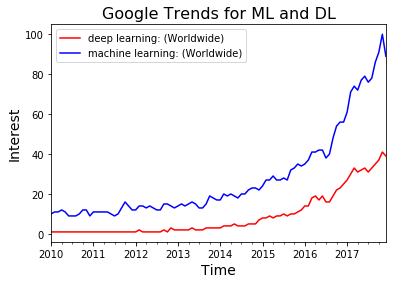

In [29]:
trends.plot(figsize=(6, 4), color=["red", "blue"])
plt.xlabel("Time", fontsize=14)
plt.ylabel("Interest", fontsize=14)
plt.title("Google Trends for ML and DL", fontsize=16)
plt.savefig("ml_interest_trends.png", dpi=200, bbox_inches="tight")

In [4]:
lorenz_data = pd.read_csv("../exp_u/lorenz_combined_output.csv")

In [57]:
y_cols = lorenz_data.columns[lorenz_data.columns.str.contains("Y")]


In [408]:
class SubModelANN(object):
    def __init__(self, inputs=1, hidden_layers=2, hidden_neurons=8,
                 activation="selu", l2_weight=0.01, learning_rate=0.001, loss="mse",
                 noise_sd=1, beta_1=0.9, model_path=None, dropout_alpha=0.5,
                 num_epochs=10, batch_size=1024, verbose=0, model_config=0):
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.l2_weight = l2_weight
        self.learning_rate = learning_rate
        self.loss = loss
        self.beta_1 = beta_1
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_config = model_config

        if model_path is None:
            nn_input = Input((inputs, ))
            nn_model = nn_input
            for h in range(hidden_layers):
                nn_model = Dense(hidden_neurons, kernel_regularizer=l2(l2_weight))(nn_model)
                if activation == "leaky":
                    nn_model = LeakyReLU(0.1)(nn_model)
                else:
                    nn_model = Activation(activation)(nn_model)
                nn_model = Dropout(dropout_alpha)(nn_model)
                nn_model = GaussianNoise(noise_sd)(nn_model)
            nn_model = Dense(1)(nn_model)
            self.model = Model(nn_input, nn_model)
            self.model.compile(Adam(lr=learning_rate, beta_1=beta_1), loss=loss)
            self.x_scaling_file = None
            self.x_scaling_values = None
        elif type(model_path) == str:
            self.model = load_model(model_path)
            model_path_start = join(model_path.split("/")[:-1])
            self.x_scaling_file = join(model_path_start, "gan_X_scaling_values_{0}.csv".format(self.model_config))
            self.x_scaling_values = pd.read_csv(self.x_scaling_file, index_col="Channel")

    def fit(self, cond_x, u):
        norm_x, self.x_scaling_values = normalize_data(np.expand_dims(cond_x, 1),
                                                       scaling_values=self.x_scaling_values)
        self.model.fit(norm_x[:, :, 0], u, batch_size=self.batch_size, epochs=self.num_epochs, verbose=self.verbose)

    def predict(self, cond_x):
        norm_x = normalize_data(np.expand_dims(cond_x, axis=2), scaling_values=self.x_scaling_values)[0][:, :, 0]
        sample_predict = K.function([self.model.input, K.learning_phase()], [self.model.output])
        sampled_u = sample_predict([norm_x, 1])[0]
        return sampled_u.ravel()

In [146]:
u_vals = lorenz_data[y_cols].sum(axis=1)

In [409]:
ann = SubModelANN(inputs=1, hidden_layers=2, hidden_neurons=12, batch_size=512, 
                  activation="leaky", verbose=1, noise_sd=1.99, dropout_alpha=0.4)
ann.fit(lorenz_data[["X_t"]].values, u_vals)
ann_preds = ann.predict(lorenz_data[["X_t"]].values)
ann_res = ann_preds - u_vals
print(ann_res.std())

Epoch 1/10
319680/319680 [==============================] - 3s - loss: 38.1605     
Epoch 2/10
319680/319680 [==============================] - 2s - loss: 22.5936     
Epoch 3/10
319680/319680 [==============================] - 2s - loss: 18.1208     
Epoch 4/10
319680/319680 [==============================] - 3s - loss: 16.1677     
Epoch 5/10
319680/319680 [==============================] - 2s - loss: 14.9780     
Epoch 6/10
319680/319680 [==============================] - 3s - loss: 14.1466     
Epoch 7/10
319680/319680 [==============================] - 3s - loss: 13.6237     
Epoch 8/10
319680/319680 [==============================] - 3s - loss: 13.2509     
Epoch 9/10
319680/319680 [==============================] - 3s - loss: 12.9984     
Epoch 10/10
319680/319680 [==============================] - 3s - loss: 12.8064     
3.4025975265713773


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


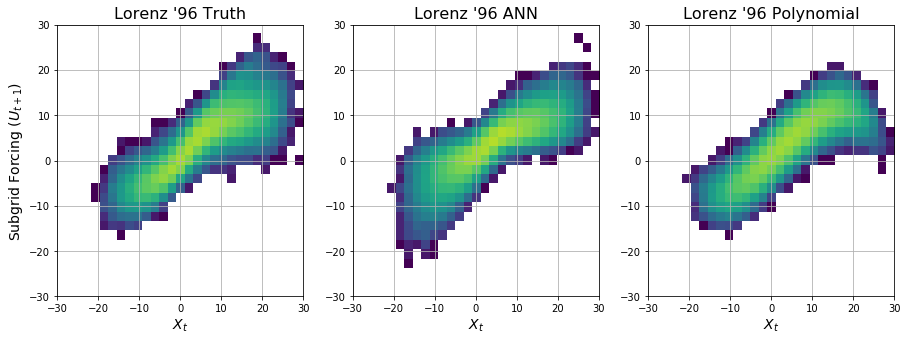

In [410]:
epoch = 10
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = axes[0].hist2d(lorenz_data["X_t"], lorenz_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(lorenz_data["X_t"], ann_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
_ = axes[2].hist2d(lorenz_data["X_t"], poly_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 ANN".format(epoch), fontsize=16)
axes[2].set_title("Lorenz '96 Polynomial".format(epoch), fontsize=16)

for a in range(3):
    axes[a].set_xlabel("$X_t$", fontsize=14)
    axes[a].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)
#plt.savefig("../exp_u/gan_x_u_hist_epoch_{0}.png".format(epoch), dpi=200, bbox_inches="tight")

In [396]:
poly_det = SubModelPoly(num_terms=3, noise_type="det")
poly_det.fit(lorenz_data["X_t"].values, lorenz_data[y_cols].sum(axis=1))
poly_det_preds = poly_det.predict(lorenz_data[["X_t"]], np.zeros(lorenz_data["X_t"].shape))

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


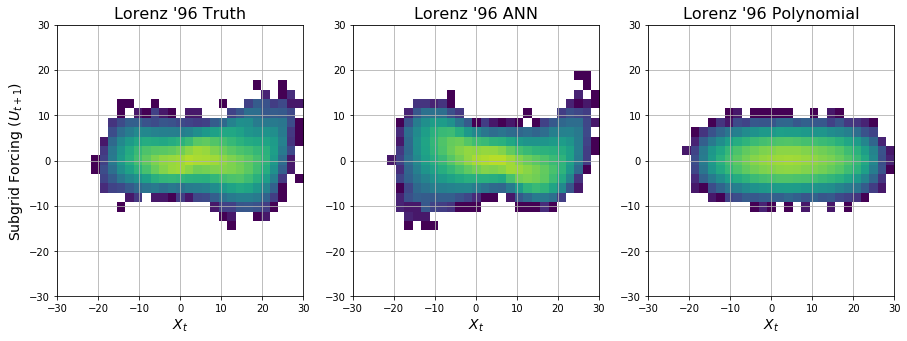

In [411]:
epoch = 10
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = axes[0].hist2d(lorenz_data["X_t"], lorenz_data[y_cols].sum(axis=1) - poly_det_preds, bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(lorenz_data["X_t"], ann_preds - poly_det_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
_ = axes[2].hist2d(lorenz_data["X_t"], poly_preds - poly_det_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 ANN".format(epoch), fontsize=16)
axes[2].set_title("Lorenz '96 Polynomial".format(epoch), fontsize=16)

for a in range(3):
    axes[a].set_xlabel("$X_t$", fontsize=14)
    axes[a].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)

In [414]:
lorenz_data["X_t"]

0          5.660486
1          7.336052
2          9.120433
3         10.972782
4         12.816656
5         14.340380
6         14.885148
7         13.635075
8         10.134742
9          4.575421
10        -1.596682
11        -6.586914
12        -9.248610
13        -9.347356
14        -7.367540
15        -4.063402
16        -0.180645
17         3.407572
18         6.054032
19         7.512947
20         7.825229
21         7.227141
22         6.102857
23         4.849446
24         3.831691
25         3.196273
26         2.925023
27         2.917089
28         3.039210
29         3.254492
            ...    
319650    -0.314222
319651     1.275392
319652     2.625272
319653     3.655131
319654     4.159126
319655     3.879882
319656     2.731074
319657     1.196170
319658     0.319069
319659     0.839592
319660     2.298748
319661     3.114654
319662     1.982095
319663    -1.201959
319664    -5.257030
319665    -8.269689
319666    -8.760392
319667    -6.832932
319668    -3.908874


In [424]:
bins = np.arange(-30, 32, 2)
res_sds = np.zeros(bins.shape[0] - 1)
res_values = lorenz_data[y_cols].sum(axis=1).values - ann_preds
for b, bin_val in enumerate(bins[:-1]):
    idxs = np.where((lorenz_data["X_t"].values >=bin_val) & (lorenz_data["X_t"].values < bins[b + 1]))[0]
    if len(idxs) > 0:
        res_sds[b] = res_values[idxs].std()

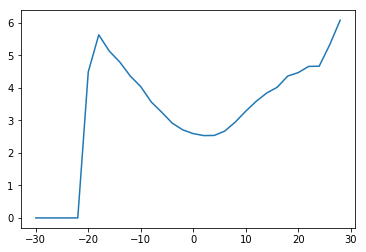

In [425]:
plt.plot(bins[:-1], res_sds)

In [142]:
poly_res = poly_det_preds - lorenz_data[y_cols].sum(axis=1)
poly_res.std()

2.3337782171445993

In [143]:
rand_x = norm.rvs(scale=poly_res.std(), size=lorenz_data[["X_t"]].shape)
poly = SubModelPoly(num_terms=3, noise_type="additive")
poly.fit(lorenz_data["X_t"].values, lorenz_data[y_cols].sum(axis=1))
poly_preds = poly.predict(lorenz_data[["X_t"]], rand_x)

In [128]:
poly_mult = SubModelPoly(num_terms=3, noise_type="multiplicative")
poly_mult.fit(lorenz_data["X_t"].values, lorenz_data[y_cols].sum(axis=1))
poly_mult_preds = poly_mult.predict(lorenz_data[["X_t"]], rand_x)

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


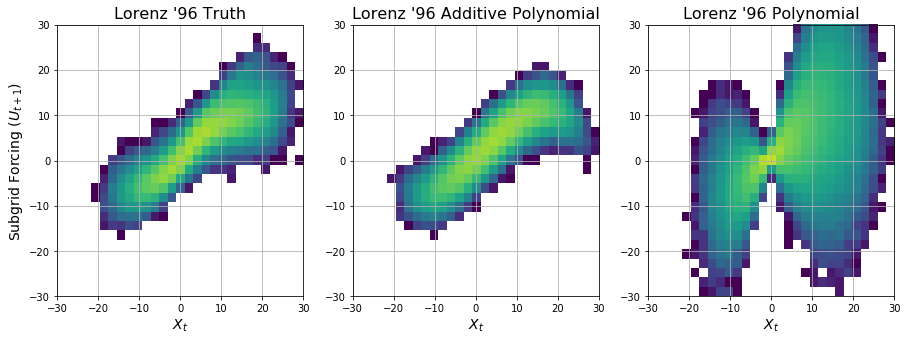

In [145]:
epoch = 10
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = axes[0].hist2d(lorenz_data["X_t"], lorenz_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(lorenz_data["X_t"], poly_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
_ = axes[2].hist2d(lorenz_data["X_t"], poly_mult_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 Additive Polynomial".format(epoch), fontsize=16)
axes[2].set_title("Lorenz '96 Polynomial".format(epoch), fontsize=16)

for a in range(3):
    axes[a].set_xlabel("$X_t$", fontsize=14)
    axes[a].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)

In [123]:
truth_data = xr.open_dataset("../exp_u/lorenz_output.nc")
truth_data["lorenz_x"][:, 0]

<xarray.DataArray 'lorenz_x' (time: 399600)>
[399600 values with dtype=float64]
Coordinates:
  * time     (time) float64 2.0 2.005 2.01 2.015 2.02 2.025 2.03 2.035 2.04 ...
    x        int64 0
Attributes:
    units:      
    long_name:  lorenz_x

In [124]:
ar1 = AR1RandomUpdater()
ar1.fit(truth_data["lorenz_x"][:, 0])

In [127]:
ar1.corr

0.99852411747413328

In [163]:
x_row = truth_data["lorenz_x"][:, 0].values

In [186]:
poly_x = poly_det.predict(x_row.reshape(-1,1), np.zeros(x_row.shape))
poly_res = poly_x - x_row

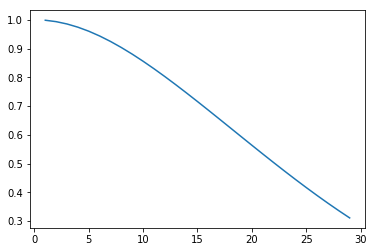

In [184]:
shifts = np.arange(1, 30)
corrs = np.zeros(shifts.shape)
for s, shift in enumerate(shifts):
    corrs[s] = pd.Series(x_row - poly_x).autocorr(shift)
plt.plot(shifts, corrs)

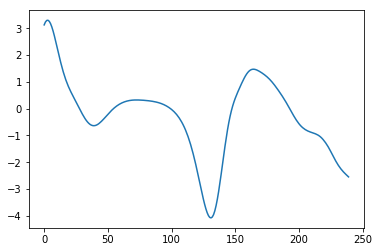

In [191]:
plt.plot(poly_res[60: 300])

In [445]:
res_net_det = Input((1,))
res_net = Dense(6)(res_net_det)
res_net = Activation("selu")(res_net)
res_net = Dropout(0.5)(res_net)
res_net = GaussianNoise(1)(res_net)
res_net = Dense(6)(res_net)
res_net = Activation("selu")(res_net)
res_net = Dropout(0.5)(res_net)
res_net = GaussianNoise(1)(res_net)
res_net = Dense(3)(res_net)
res_net_model = Model(res_net_det, res_net)
res_net_model.compile("adam", "mse")
print(res_net_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_146 (Dense)            (None, 6)                 12        
_________________________________________________________________
activation_90 (Activation)   (None, 6)                 0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 6)                 0         
_________________________________________________________________
gaussian_noise_21 (GaussianN (None, 6)                 0         
_________________________________________________________________
dense_147 (Dense)            (None, 6)                 42        
_________________________________________________________________
activation_91 (Activation)   (None, 6)                 0         
__________

In [310]:
outputs = np.zeros((poly_res.shape[0] - 6, 3))
for i in range(poly_res.shape[0] - 6):
    outputs[i] = poly_res[i+1:i+4]
    

In [321]:
res_net_model.layers[-4].get_weights()

[array([[ 0.20663193, -0.34509084,  0.23296945],
        [ 0.46442187, -0.00123744, -0.31755602]], dtype=float32),
 array([ 2.20410872,  1.96106398,  2.90702581], dtype=float32)]

In [446]:

res_net_model.fit(np.expand_dims(poly_res[:-6], axis=-1), outputs, batch_size=256, epochs=15)

Epoch 1/15
399594/399594 [==============================] - 6s - loss: 6.1414     
Epoch 2/15
399594/399594 [==============================] - 5s - loss: 3.1357     
Epoch 3/15
399594/399594 [==============================] - 6s - loss: 2.9551     
Epoch 4/15
399594/399594 [==============================] - 6s - loss: 2.9169     
Epoch 5/15
399594/399594 [==============================] - 6s - loss: 2.8955     
Epoch 6/15
399594/399594 [==============================] - 6s - loss: 2.8887     
Epoch 7/15
399594/399594 [==============================] - 6s - loss: 2.8715     
Epoch 8/15
399594/399594 [==============================] - 7s - loss: 2.8637     
Epoch 9/15
399594/399594 [==============================] - 6s - loss: 2.8656     
Epoch 10/15
399594/399594 [==============================] - 7s - loss: 2.8460     
Epoch 11/15
399594/399594 [==============================] - 7s - loss: 2.8796     
Epoch 12/15
399594/399594 [==============================] - 8s - loss: 2.8582     
E

In [447]:
stoch_pred = K.function([res_net_model.input, K.learning_phase()], [res_net_model.output])
num_preds = 1000
inputs = np.arange(-3, 4)
stoch_outputs = pd.DataFrame(index=np.arange(num_preds), columns=inputs, dtype=float)
for i, in_val in enumerate(inputs):
    for n in range(num_preds):
        stoch_outputs.iloc[n, i] = stoch_pred([np.array([[in_val]]), 1])[0][0,0]

In [348]:
def ar1_pred(x):
    corr = 0.986
    sd = 1.99
    return corr * x + sd * (1 - corr ** 2) ** 0.5 * norm.rvs() 

num_preds = 1000
inputs = np.arange(-3, 4)
ar1_outputs = pd.DataFrame(index=np.arange(num_preds), columns=inputs, dtype=float)
for i, in_val in enumerate(inputs):
    for n in range(num_preds):
        ar1_outputs.iloc[n, i] = ar1_pred(in_val)

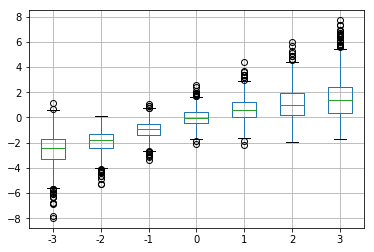

In [448]:
stoch_outputs.boxplot()

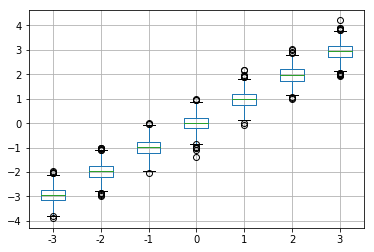

In [449]:
ar1_outputs.boxplot()

In [304]:
1.99 * (1 - .986**2) ** 0.5 * 6

1.9909390584344886

In [297]:
(1 - .986**2) ** 0.5

0.16674531477675783

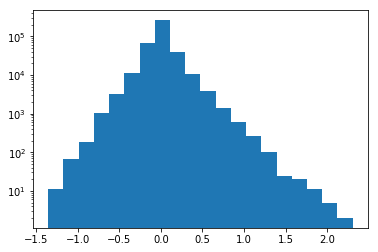

In [270]:
plt.hist(poly_res[1:] - poly_res[:-1], 20)
plt.gca().set_yscale("log")

(array([  1.92000000e+02,   9.86000000e+02,   5.00100000e+03,
          1.40220000e+04,   4.68960000e+04,   2.79986000e+05,
          4.96490000e+04,   2.70100000e+03,   1.46000000e+02,
          2.10000000e+01]),
 array([-21.63609865, -17.78862082, -13.941143  , -10.09366518,
         -6.24618736,  -2.39870953,   1.44876829,   5.29624611,
          9.14372393,  12.99120176,  16.83867958]),
 <a list of 10 Patch objects>)

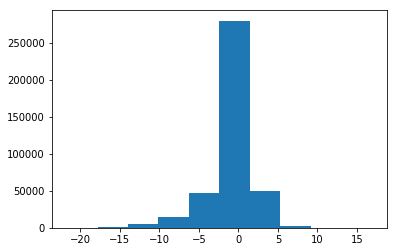

In [277]:
plt.hist(poly_res)

In [25]:
class SubModelPolyAdd(object):
    def __init__(self, num_terms=3):
        self.num_terms = num_terms
        self.model = LinearRegression()
        self.res_sd = 0
        self.corr = 1

    def fit(self, x, u):
        x_terms = np.zeros((x.shape[0], self.num_terms))
        for p in range(1, self.num_terms + 1):
            x_terms[:, p - 1] = x[:, 0] ** p
        self.model.fit(x_terms, u)
        u_mean = self.model.predict(x_terms)
        residuals = u - u_mean
        self.corr = np.corrcoef(residuals[1:], residuals[:-1])[0, 1]
        self.res_sd = np.std(residuals)

    def predict(self, x, residuals=None):
        if residuals is None:
            residuals = np.zeros(x.shape[0])
        x_terms = np.zeros((x.shape[0], self.num_terms))
        for p in range(1, self.num_terms + 1):
            x_terms[:, p - 1] = x[:, 0] ** p
        u_mean = self.model.predict(x_terms)
        u_res = self.corr * residuals + \
            self.res_sd * np.sqrt(1 - self.corr ** 2) * np.random.normal(size=residuals.shape)
        return u_mean, u_res
    
class SubModelANNRes(object):
    def __init__(self, mean_inputs=1, hidden_layers=2, hidden_neurons=8,
                 activation="selu", l2_weight=0.01, learning_rate=0.001, loss="mse",
                 noise_sd=1, beta_1=0.9, model_path=None, dropout_alpha=0.5,
                 num_epochs=10, batch_size=1024, val_split=0.5, verbose=0, model_config=0):
        self.config = dict(mean_inputs=mean_inputs,
                           hidden_layers=hidden_layers,
                           hidden_neurons=hidden_neurons,
                           activation=activation,
                           l2_weight=l2_weight,
                           learning_rate=learning_rate,
                           loss=loss,
                           noise_sd=noise_sd,
                           beta_1=beta_1,
                           dropout_alpha=dropout_alpha,
                           model_path=model_path,
                           num_epochs=num_epochs,
                           batch_size=batch_size,
                           verbose=verbose,
                           model_config=model_config,
                           val_split=val_split)
        if model_path is None:
            nn_input = Input((mean_inputs,))
            nn_model = nn_input
            for h in range(hidden_layers):
                nn_model = Dense(hidden_neurons, kernel_regularizer=l2(l2_weight))(nn_model)
                if activation == "leaky":
                    nn_model = LeakyReLU(0.1)(nn_model)
                else:
                    nn_model = Activation(activation)(nn_model)
            nn_model = Dense(1)(nn_model)
            nn_res_input_x = Input((mean_inputs,))
            nn_res_input_res = Input((1,))
            nn_res = concatenate([nn_res_input_x, nn_res_input_res])
            for h in range(hidden_layers):
                nn_res = Dense(hidden_neurons, kernel_regularizer=l2(l2_weight))(nn_res)
                if activation == "leaky":
                    nn_res = LeakyReLU(0.1)(nn_res)
                else:
                    nn_res = Activation(activation)(nn_res)
                nn_res = Dropout(dropout_alpha)(nn_res)
                nn_res = GaussianNoise(noise_sd)(nn_res)
            nn_res = Dense(1)(nn_res)
            self.mean_model = Model(nn_input, nn_model)
            self.mean_model.compile(Adam(lr=learning_rate, beta_1=beta_1), loss=loss)
            self.res_model = Model([nn_res_input_x, nn_res_input_res], nn_res)
            self.res_model.compile(Adam(lr=learning_rate, beta_1=beta_1), loss=loss)
            self.x_scaling_file = None
            self.x_scaling_values = None
        elif type(model_path) == str:
            mean_model_file = join(model_path, "ann_res_config_{0:04d}_mean.nc".format(self.config["model_config"]))
            res_model_file = join(model_path, "ann_res_config_{0:04d}_res.nc".format(self.config["model_config"]))
            self.mean_model = load_model(mean_model_file)
            self.res_model = load_model(res_model_file)
            self.x_scaling_file = join(model_path, "gan_X_scaling_values_{0}.csv".format(model_config))
            self.x_scaling_values = pd.read_csv(self.x_scaling_file, index_col="Channel")
        self.res_predict = K.function(self.res_model.input + [K.learning_phase()], [self.res_model.output])

    def fit(self, cond_x, u):
        split_index = int(cond_x.shape[0] * self.config["val_split"])
        norm_x, self.x_scaling_values = normalize_data(cond_x,
                                                       scaling_values=self.x_scaling_values)
        self.mean_model.fit(norm_x[:split_index], u[:split_index], batch_size=self.config["batch_size"],
                            epochs=self.config["num_epochs"],
                            verbose=self.config["verbose"])
        mean_preds = self.mean_model.predict(norm_x[split_index:]).ravel()
        residuals = u[split_index:] - mean_preds
        self.res_model.fit([norm_x[split_index:-1], residuals[:-1].reshape(-1, 1)], 
                           residuals[1:], batch_size=self.config["batch_size"],
                           epochs=self.config["num_epochs"],
                           verbose=self.config["verbose"])

    def predict(self, cond_x, residuals):
        norm_x = normalize_data(cond_x, scaling_values=self.x_scaling_values)[0]
        u_mean = self.mean_model.predict(norm_x).ravel()
        u_res = self.res_predict([norm_x, residuals, 1])[0].ravel()
        return u_mean, u_res

    def save_model(self, out_path):
        out_config_file = join(out_path, "ann_res_config_{0:04d}_opts.yaml".format(self.config["model_config"]))
        with open(out_config_file, "w") as out_config:
            yaml.dump(self.config, out_config)
        mean_model_file = join(out_path, "ann_res_config_{0:04d}_mean.nc".format(self.config["model_config"]))
        res_model_file = join(out_path, "ann_res_config_{0:04d}_res.nc".format(self.config["model_config"]))
        save_model(self.mean_model, mean_model_file)
        save_model(self.res_model, res_model_file)
        self.x_scaling_values.to_csv(self.x_scaling_file, index_label="Channel")
        
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the multi dimensional data matrix independently.

    Args:
        data: multi-dimensional array with dimensions (example, ..., channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
        for i in range(data.shape[-1]):
            scaling_values.loc[i, ["mean", "std"]] = [data[..., i].mean(), data[..., i].std()]
    for i in range(data.shape[-1]):
        normed_data[..., i] = (data[..., i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[..., i] = normed_data[..., i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

In [8]:
truth_data = xr.open_dataset("../exp_u/lorenz_output.nc")
x_0 = truth_data["lorenz_x"][:-1, 0].values.reshape(-1, 1)
u_0 = truth_data["lorenz_y"][1:, 0:32].sum(axis=1).values
truth_data.close()
split = 200000

In [9]:
poly_add = SubModelPolyAdd()
poly_add.fit(x_0[:split], u_0[:split])

In [10]:
poly_add.res_sd

2.3243622812289204

In [11]:
res_init = np.array([[0]], dtype=float)
u_mean_poly = np.zeros(x_0[split:].size - 1)
u_res_poly = np.zeros(x_0[split:].size - 1)
for i in range(x_0[split:].size - 1):
    u_mean_poly[i], u_res_poly[i] = poly_add.predict(x_0[split + i:split + i +1].reshape((1,1)), res_init)
    res_init[0, 0] = u_res_poly[i]
    if i % 1000 == 0:
        print(i, u_res_poly[i], res_init[0,0])

0 0.0380557311629 0.0380557311629
1000 1.63719009337 1.63719009337
2000 3.03190540914 3.03190540914
3000 -1.72470539421 -1.72470539421
4000 0.827136235133 0.827136235133
5000 0.558129794138 0.558129794138
6000 -1.29246294289 -1.29246294289
7000 1.85003791961 1.85003791961
8000 3.87887771745 3.87887771745
9000 1.63211714608 1.63211714608
10000 2.02019365204 2.02019365204
11000 2.24698996735 2.24698996735
12000 3.02185077941 3.02185077941
13000 3.24943826754 3.24943826754
14000 4.09805622966 4.09805622966
15000 -3.37940614617 -3.37940614617
16000 -1.93022183295 -1.93022183295
17000 -1.01734572935 -1.01734572935
18000 2.22577250503 2.22577250503
19000 1.47987507936 1.47987507936
20000 2.86877146478 2.86877146478
21000 -1.76838344427 -1.76838344427
22000 0.508331235604 0.508331235604
23000 1.62965376861 1.62965376861
24000 -1.89943359213 -1.89943359213
25000 -2.36535049468 -2.36535049468
26000 0.827080460498 0.827080460498
27000 5.71790605582 5.71790605582
28000 -1.66674578844 -1.666745788

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


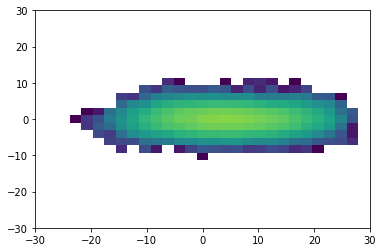

In [647]:
_ = plt.hist2d(x_0[split:-1], u_res_poly, bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))

In [38]:
ann_res = SubModelANNRes(hidden_layers=2, hidden_neurons=4, l2_weight=0.001, num_epochs=20, noise_sd=3, verbose=1)

In [39]:
ann_res.fit(x_0[:split].reshape(-1, 1), u_0[:split])

Epoch 1/20
100000/100000 [==============================] - 0s - loss: 48.1598     
Epoch 2/20
100000/100000 [==============================] - 0s - loss: 33.2508     
Epoch 3/20
100000/100000 [==============================] - 0s - loss: 17.9960     
Epoch 4/20
100000/100000 [==============================] - 0s - loss: 8.7644     
Epoch 5/20
100000/100000 [==============================] - 0s - loss: 5.7477     
Epoch 6/20
100000/100000 [==============================] - 0s - loss: 5.2776     
Epoch 7/20
100000/100000 [==============================] - 0s - loss: 5.2329     
Epoch 8/20
100000/100000 [==============================] - 0s - loss: 5.2227     
Epoch 9/20
100000/100000 [==============================] - 0s - loss: 5.2141     
Epoch 10/20
100000/100000 [==============================] - 0s - loss: 5.2059     
Epoch 11/20
100000/100000 [==============================] - 0s - loss: 5.1982     
Epoch 12/20
100000/100000 [==============================] - 0s - loss: 5.1911    

In [40]:
res_init = np.array([[0]], dtype=float)
u_mean_ann = np.zeros(x_0[split:].size - 1)
u_res_ann = np.zeros(x_0[split:].size - 1)
for i in range(x_0[split:].size - 1):
    u_mean_ann[i], u_res_ann[i] = ann_res.predict(x_0[split + i:split + i +1].reshape((1,1)), res_init)
    res_init[0, 0] = u_res_ann[i]
    if i % 1000 == 0:
        print(i, u_mean_ann[i], u_res_ann[i])

0 -7.01611995697 -0.0140057206154
1000 3.39555335045 1.09885883331
2000 7.89811182022 0.869324684143
3000 6.79987812042 0.904703855515
4000 2.78841900826 0.378662288189
5000 6.45381355286 0.195666790009
6000 8.74396133423 -0.126169353724
7000 7.67370176315 -0.0502350330353
8000 4.92549180984 1.66333556175
9000 8.02894020081 -2.12587976456
10000 10.8649778366 0.0883913636208
11000 5.74653911591 -1.31633400917
12000 -2.47604370117 0.887017726898
13000 7.71337890625 1.69285488129
14000 4.77841711044 0.599713742733
15000 5.64993429184 -0.384851098061
16000 -5.84090280533 0.78992497921
17000 -3.39082407951 0.355930328369
18000 0.56045037508 -0.454356789589
19000 6.0931725502 -0.0967429876328
20000 4.12952947617 0.342739701271
21000 6.14447021484 -0.493115901947
22000 8.66479301453 0.616275548935
23000 9.22922992706 -0.716852903366
24000 2.65954327583 0.304649621248
25000 10.9581890106 0.609984338284
26000 10.2853736877 -0.409015893936
27000 -4.53600025177 -0.318144619465
28000 -1.2471212148

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


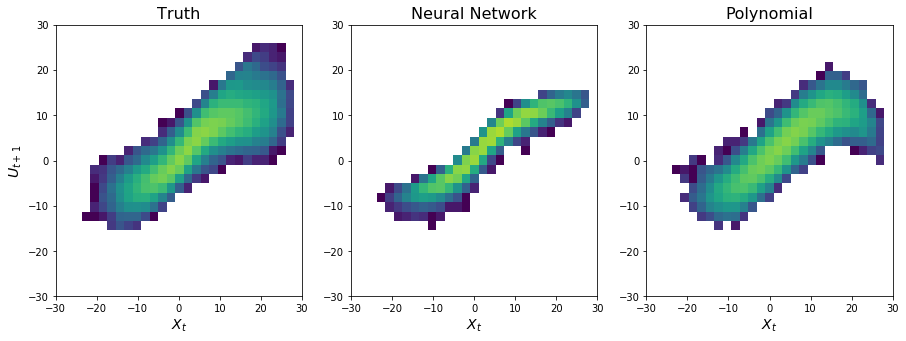

In [42]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
_ = plt.hist2d(x_0[split:-1, 0], u_0[split:-1],bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
plt.title("Truth", fontsize=16)
plt.xlabel("$X_t$", fontsize=14)

plt.ylabel("$U_{t+1}$", fontsize=14)
plt.subplot(1, 3, 2)
_ = plt.hist2d(x_0[split:-1, 0], u_mean_ann + u_res_ann, bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
plt.title("Neural Network", fontsize=16)
plt.xlabel("$X_t$", fontsize=14)

plt.subplot(1,3 ,3)
_ = plt.hist2d(x_0[split:-1, 0], u_mean_poly + u_res_poly, bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
plt.title("Polynomial", fontsize=16)
plt.xlabel("$X_t$", fontsize=14)


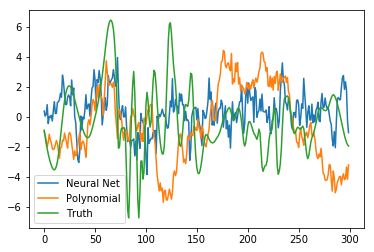

In [37]:
i_start = 600
i_end = 900
plt.plot(u_res_ann[i_start:i_end], label="Neural Net")
#plt.plot(u_mean_poly[i_start:i_end], label="Polynomial")
plt.plot(u_res_poly[i_start:i_end], label="Polynomial")
plt.plot(u_0[split:][i_start+1: i_end+1] - u_mean_ann[i_start:i_end], label="Truth")
plt.legend()

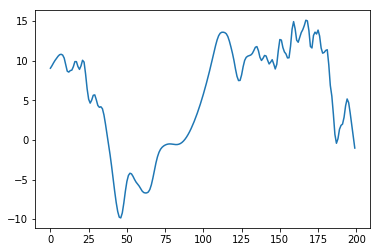

In [598]:
l_20 = xr.open_dataset("../exp_20/lorenz_output.nc")

In [599]:
l_20_u = l_20["lorenz_y"][:, 0:32].sum(axis=1).values

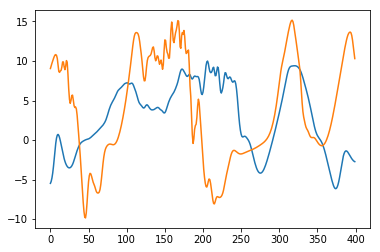

In [608]:
plt.plot(l_20_u[:400])
plt.plot(u_0[:400])

In [604]:
l_20_u.min()

-9.6262556217496371